In [1]:
import pandas as pd
import counterfactual_precipitation as cp
import geopandas as gpd
import pyproj
from osgeo import osr
import wradlib as wrl
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.colors import BoundaryNorm
import matplotlib
from matplotlib.colorbar import ColorbarBase

In [3]:
# create the files for the projection information
radolanwkt = """PROJCS["Radolan Projection",
    GEOGCS["Radolan Coordinate System",
        DATUM["Radolan_Kugel",
            SPHEROID["Erdkugel",6370040,0]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]]],
    PROJECTION["Polar_Stereographic"],
    PARAMETER["latitude_of_origin",90],
    PARAMETER["central_meridian",10],
    PARAMETER["scale_factor",0.933012701892],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["kilometre",1,
        AUTHORITY["EPSG","9036"]],
    AXIS["Easting",SOUTH],
    AXIS["Northing",SOUTH]]
"""
radolanproj = pyproj.CRS.from_wkt(radolanwkt)
proj_stereo = wrl.georef.create_osr("dwd-radolan-sphere")

# This is our target projection (UTM)
proj_utm = osr.SpatialReference()
proj_utm.ImportFromEPSG(32632)


event_id = "WG/Jul21"
subbasins = gpd.read_file("output/gis/subbasins_info.gpkg")
#project the subbasin shapefile to UTM
subbasins_utm = subbasins.to_crs("EPSG:32632")
subbasins_utm = subbasins_utm[["sub_id", "geometry"]]
subbasins_utm.to_file("output/gis/subbasins_utm.gpkg")

subbasins = subbasins.to_crs(radolanproj)

event = xr.open_dataset("input/nw_jul21.nc")
event = event.rainfall_amount

#get the coordinates of the centroid
t_max, y_max, x_max = np.argwhere(event.values == np.nanmax(event.values))[0]
centroid_x_coord = event.x[x_max].item()
centroid_y_coord = event.y[y_max].item()
original_centroid = (centroid_x_coord, centroid_y_coord)

if not os.path.exists("output/precipitation"):
    os.mkdir("output/precipitation")

DriverError: 'output/gis/subbasins_info.gpkg' not recognized as a supported file format.

## Extract precipitation time series for the original event (-999) and all counterfactuals
For this we use the same function as below but we manipulate the subbasin shapefile and add one basin, which has the same centroid as the centroid of the original event. The subbasin ID -999 desribes the event in its original spatial position.

In [3]:
original_event = {"sub_id": -999, "geometry": subbasins.geometry[0]} #the geometry column won't be used, so we just copy another geometry
original_event = gpd.GeoDataFrame([original_event], geometry='geometry')
original_event.set_crs(radolanproj, inplace=True)

subbasins = gpd.GeoDataFrame(pd.concat([subbasins, original_event], ignore_index=True))

if not os.path.exists("output/basins/-999"):
    os.mkdir("output/basins/-999")

In [ ]:
for id in subbasins.sub_id.to_list():
    cp.get_rainseries_from_radklim(subbasin_id=id,
                               event_id="nw_jul21",
                               subbasins_radolanproj=subbasins,
                               original_event=event,
                               original_centroid=original_centroid,
                               radolan_projection=radolanproj,
                               utm_projection=proj_utm,
                               stereo_projection=proj_stereo
                               )


## Calculate effective precipitation
We now transform the RADKLIM precipitation time series into effective precipitation. The curve numbers of the basins are stored in **output/gis/CN_subbasins_table.csv**

In [5]:
if not os.path.exists('output/effective_rainfall'):
    os.mkdir('output/effective_rainfall')

subbasins = gpd.read_file("output/gis/subbasins_info.gpkg")

for id in subbasins.sub_id.to_list():
    cp.get_effective_rainfall(id)

Sub ID 1
Sub ID 2
Sub ID 3
Sub ID 4
Sub ID 5
Sub ID 6
Sub ID 7
Sub ID 8
Sub ID 9
Sub ID 10
Sub ID 11
Sub ID 12
Sub ID 13
Sub ID 14
Sub ID 15
Sub ID 16
Sub ID 17
Sub ID 18
Sub ID 19
Sub ID 20
Sub ID 21
Sub ID 22
Sub ID 23
Sub ID 24
Sub ID 25
Sub ID 26
Sub ID 27
Sub ID 28
Sub ID 29
Sub ID 30
Sub ID 31
Sub ID 32
Sub ID 33
Sub ID 34
Sub ID 35
Sub ID 36
Sub ID 37
Sub ID 38
Sub ID 39
Sub ID 40
Sub ID 41
Sub ID 42
Sub ID 43
Sub ID 44
Sub ID 45
Sub ID 46
Sub ID 47
Sub ID 48
Sub ID 49
Sub ID 50
Sub ID 51
Sub ID 52
Sub ID 53
Sub ID 54
Sub ID 55
Sub ID 56
Sub ID 57


If all these steps ran succesfully, we now have generated all input data necessary for the modelling of quick runoff. Proceed with Part 3

## Visualize counterfactuals
Here we show the spatial position of the counterfactuals within Germany. Since we shift the rainfall events to the centroid of every subbasins, you can put any ID of a subbasin here and visualize the rainfall event (rainfall sums) in this example. The original rainfall event ("NW/Jul21") in its original spatial position has the ID "-999". 

In [46]:
subbasin_id = -999
ger = gpd.read_file("input/NUTS5000_N1.shp")
subbasins = gpd.read_file("output/gis/subbasins.gpkg")
ger.to_crs(radolanproj, inplace=True)
subbasins_radolanproj = subbasins.to_crs(radolanproj)

radolanwkt = """PROJCS["Radolan Projection",
    GEOGCS["Radolan Coordinate System",
        DATUM["Radolan_Kugel",
            SPHEROID["Erdkugel",6370040,0]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]]],
    PROJECTION["Polar_Stereographic"],
    PARAMETER["latitude_of_origin",90],
    PARAMETER["central_meridian",10],
    PARAMETER["scale_factor",0.933012701892],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["kilometre",1,
        AUTHORITY["EPSG","9036"]],
    AXIS["Easting",SOUTH],
    AXIS["Northing",SOUTH]]
"""

radolanproj = pyproj.CRS.from_wkt(radolanwkt)

DriverError: output/gis/subbasins_info.gpkg: No such file or directory

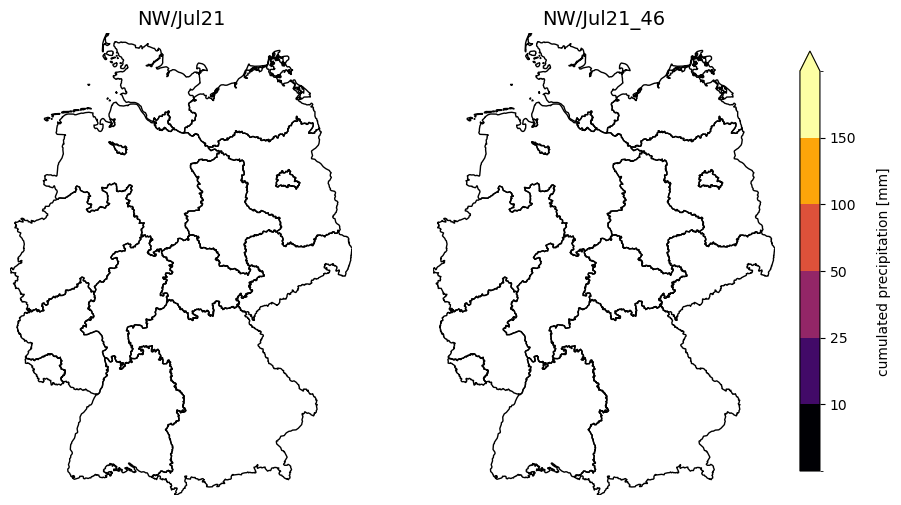

In [49]:
#shift to subbasin
id = 46

original_event = xr.open_dataset("input/nw_jul21.nc")
original_event = original_event.rainfall_amount

#get the coordinates of the centroid
t_max, y_max, x_max = np.argwhere(original_event.values == np.nanmax(original_event.values))[0]
centroid_x_coord = original_event.x[x_max].item()
centroid_y_coord = original_event.y[y_max].item()
original_centroid = (centroid_x_coord, centroid_y_coord)

fig, ax = plt.subplots(figsize=(10,6), nrows=1, ncols=2)
ax = ax.flatten()

bb = tuple(ger.total_bounds.tolist())

maximum_rain = np.argwhere(original_event.values == np.nanmax(original_event.values))[0]
y_max = maximum_rain[1]
x_max = maximum_rain[2]
t_max = maximum_rain[0]

y_max_coord = original_event.y[y_max].values
x_max_coord = original_event.x[x_max].values

original_event = original_event.sum("time", skipna=True)

# Define class boundaries and labels
class_boundaries = [0, 10, 25, 50, 100, 150, 300] # Example class boundaries
class_labels = ["$<10$", "$10-25$", "$25-50$", "$50-100$", "$100-150$", "$150>$"]  # Corresponding class labels

# Map the data values to their corresponding classes
classified_data = np.digitize(original_event.values, bins=class_boundaries, right=True)
classified_data = np.select([classified_data <= 0, classified_data >= len(class_labels)], 
                        [0, len(class_labels) - 1], 
                        default=classified_data)

original_event.values = classified_data

#cmap = get_cmap("inferno", len(class_labels))
cmap = plt.get_cmap(name="inferno", lut=len(class_labels))
#point of highest rainfall
centroid = gpd.GeoDataFrame(geometry=[Point(x_max_coord, y_max_coord)])
centroid.set_crs(radolanproj, inplace=True)
#centroid.to_crs("EPSG:25832", inplace=True)

original_event.plot.imshow(extent=bb, cmap=cmap, zorder=2, add_colorbar=False, add_labels=False, ax=ax[0])
ger.plot(ax=ax[0], edgecolor='black', color="None", linewidth=1, zorder=4)
centroid.plot(ax=ax[0], color="lime", marker="x", markersize=80, zorder=5)
subbasins_radolanproj.plot(ax=ax[0],zorder=6)
ax[0].set_xlim(bb[0], bb[2])
ax[0].set_ylim(bb[1], bb[3])
ax[0].set_title("NW/Jul21", fontsize=14)
ax[0].set_axis_off()

#shift the event
#get the coordinates of the centroid
centroid = subbasins_radolanproj.loc[subbasins_radolanproj.DN == id].centroid
event_counterfactual = cp.move_event(original_event, centroid, original_centroid)

event_counterfactual.plot.imshow(extent=bb, cmap=cmap, zorder=2, add_colorbar=False, add_labels=False, ax=ax[1])
ger.plot(ax=ax[1], edgecolor='black', color="None", linewidth=1, zorder=4)
centroid.plot(ax=ax[1], color="lime", marker="x", markersize=80, zorder=5)
subbasins_radolanproj.plot(ax=ax[1],zorder=6)
ax[1].set_xlim(bb[0], bb[2])
ax[1].set_ylim(bb[1], bb[3])
ax[1].set_title(f"NW/Jul21_{id}", fontsize=14)
ax[1].set_axis_off()


cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position and size as needed

# Create a BoundaryNorm for the colorbar
class_boundaries = [0, 10, 25, 50, 100, 150, 300]
class_labels = ["<10", "10-25", "25-50", "50-100", "100-150", ">150"]  # Corresponding class labels
# Calculate midpoints between class boundaries for tick positions
#tick_positions = [(class_boundaries[i] + class_boundaries[i+1]) / 2 for i in range(len(class_boundaries) - 1)]

# Add a colorbar
cmap = plt.get_cmap("inferno", len(class_labels))
norm = BoundaryNorm(class_boundaries, cmap.N)
#tick_positions
cbar = ColorbarBase(cax, cmap=cmap, ticks=class_boundaries[1:-1], norm=norm, extend="max")
#cbar.set_ticklabels(class_labels)

cbar.set_label('cumulated precipitation [mm]', rotation=90, labelpad=15)
plt.show()


In [45]:
subbasins_radolanproj

,DN,geometry
0,1,"POLYGON ((-237247.756 -4253241.739, -236644.32..."
1,2,"POLYGON ((-251861.640 -4253060.671, -250943.33..."
2,3,"MULTIPOLYGON (((-248041.405 -4253898.239, -248..."
3,4,"POLYGON ((-241786.769 -4255238.603, -241734.29..."
4,5,"POLYGON ((-240387.301 -4258676.110, -240151.10..."
5,6,"MULTIPOLYGON (((-239689.776 -4259552.949, -239..."
6,7,"POLYGON ((-248536.272 -4259575.208, -248483.78..."
7,8,"POLYGON ((-224543.478 -4263862.689, -224517.22..."
8,9,"POLYGON ((-221658.809 -4264132.129, -221632.55..."
9,10,"POLYGON ((-218426.383 -4261588.920, -218111.43..."


In [37]:
np.nanmax(original_event.values)

<bound method Mapping.values of <xarray.Dataset>
Dimensions:          (time: 116, y: 291, x: 278)
Coordinates:
  * time             (time) datetime64[ns] 2021-07-11T20:50:00 ... 2021-07-16...
    longitudes       (y, x) float64 ...
    latitudes        (y, x) float64 ...
  * x                (x) float64 -3.065e+05 -3.055e+05 ... -3.046e+04 -2.946e+04
  * y                (y) float64 -4.39e+06 -4.389e+06 ... -4.101e+06 -4.1e+06
Data variables:
    spatial_ref      int64 ...
    rainfall_amount  (time, y, x) float32 ...>